In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, concatenate, Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics

import gensim.downloader as api
import numpy as np

RANDOM_STATE=4222

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_valid = pd.read_csv('./datasets/valid.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [3]:
model = api.load("word2vec-google-news-300")

In [4]:
def get_sentence_vectors(sentence):
    tokens = sentence.split()
    vectors = [model[word] for word in tokens if word in model]
    
    if not vectors:
        return np.zeros(100)
    
    sentence_vector = np.mean(vectors, axis=0)[:100]
    return sentence_vector

In [5]:
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df_train[c] = df_train[c].apply(lambda x: get_sentence_vectors(x))
    df_valid[c] = df_valid[c].apply(lambda x: get_sentence_vectors(x))
    df_test[c] = df_test[c].apply(lambda x: get_sentence_vectors(x))
    
    print(c + ' done')

title done
company_profile done
description done
requirements done
benefits done


In [6]:
y_train = df_train['fraudulent'].values
y_valid = df_valid['fraudulent'].values
y_test = df_test['fraudulent'].values

In [7]:
def convert_to_tensors(X_train_values):
    tensors = torch.from_numpy(np.vstack(X_train_values))
    return tf.constant(tensors.numpy(), dtype=tf.float32)

def get_tensors(df_col):
    return convert_to_tensors(df_col.values)

In [8]:
X_train_title = get_tensors(df_train['title'])
X_train_company_profile = get_tensors(df_train['company_profile'])
X_train_description = get_tensors(df_train['description'])
X_train_requirements = get_tensors(df_train['requirements'])
X_train_benefits = get_tensors(df_train['benefits'])

X_valid_title = get_tensors(df_valid['title'])
X_valid_company_profile = get_tensors(df_valid['company_profile'])
X_valid_description = get_tensors(df_valid['description'])
X_valid_requirements = get_tensors(df_valid['requirements'])
X_valid_benefits = get_tensors(df_valid['benefits'])

X_test_title = get_tensors(df_test['title'])
X_test_company_profile = get_tensors(df_test['company_profile'])
X_test_description = get_tensors(df_test['description'])
X_test_requirements = get_tensors(df_test['requirements'])
X_test_benefits = get_tensors(df_test['benefits'])

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

X_train_title,y_train_resampled = smote.fit_resample(X_train_title,y_train)

X_train_company_profile,_ = smote.fit_resample(X_train_company_profile,y_train)

X_train_description,_ = smote.fit_resample(X_train_description,y_train)

X_train_requirements,_ = smote.fit_resample(X_train_requirements,y_train)

X_train_benefits,_ = smote.fit_resample(X_train_benefits,y_train)

In [10]:
def create_neural_net(input_shape):
    model = Sequential([
        Dense(input_shape, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent','title_tokens', 'company_profile_tokens',
       'description_tokens', 'requirements_tokens', 'benefits_tokens']

In [12]:
X_train_non_text = df_train.drop(columns=text_cols).values
X_valid_non_text = df_valid.drop(columns=text_cols).values
X_test_non_text = df_test.drop(columns=text_cols).values

In [13]:
X_train_non_text,_ = smote.fit_resample(X_train_non_text,y_train)

In [14]:
model_title = create_neural_net(100)
model_company_profile = create_neural_net(100)
model_description = create_neural_net(100)
model_requirements = create_neural_net(100)
model_benefits = create_neural_net(100)
model_non_text = create_neural_net(41)

In [15]:
concatenated = concatenate([model_title.output, 
                            model_company_profile.output, 
                            model_description.output, 
                            model_requirements.output, 
                            model_benefits.output,
                            model_non_text.output])


dense = Dense(32, activation='relu')(concatenated)
outputs = Dense(1, activation='sigmoid')(dense)

final_model = Model(inputs=[model_title.input, 
                    model_company_profile.input, 
                    model_description.input, 
                    model_requirements.input, 
                    model_benefits.input,
                    model_non_text.input], outputs=outputs)

In [16]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

final_model.fit([X_train_title,
                X_train_company_profile,
                X_train_description,
                X_train_requirements,
                X_train_benefits,
                X_train_non_text], y_train_resampled, epochs=100, batch_size=32, callbacks=[early_stop],
               validation_data=([X_valid_title,
                X_valid_company_profile,
                X_valid_description,
                X_valid_requirements,
                X_valid_benefits,
                X_valid_non_text], y_valid))

Epoch 1/100
745/745 [==============================] - 3s 3ms/step - loss: 0.3921 - accuracy: 0.8214 - val_loss: 0.1750 - val_accuracy: 0.9295
Epoch 2/100
745/745 [==============================] - 2s 2ms/step - loss: 0.1640 - accuracy: 0.9411 - val_loss: 0.1306 - val_accuracy: 0.9448
Epoch 3/100
745/745 [==============================] - 2s 2ms/step - loss: 0.1108 - accuracy: 0.9620 - val_loss: 0.0986 - val_accuracy: 0.9631
Epoch 4/100
745/745 [==============================] - 2s 2ms/step - loss: 0.0815 - accuracy: 0.9721 - val_loss: 0.0928 - val_accuracy: 0.9664
Epoch 5/100
745/745 [==============================] - 2s 2ms/step - loss: 0.0596 - accuracy: 0.9809 - val_loss: 0.0957 - val_accuracy: 0.9657
Epoch 6/100
745/745 [==============================] - 2s 2ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.0918 - val_accuracy: 0.9698
Epoch 7/100
745/745 [==============================] - 2s 2ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0824 - val_accuracy: 0.9758

In [18]:
def get_confusion_matrix(actual, predicted, title):
    cf = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

84/84 [==============================] - 0s 1ms/step


<AxesSubplot: xlabel='Predictions', ylabel='True Labels'>

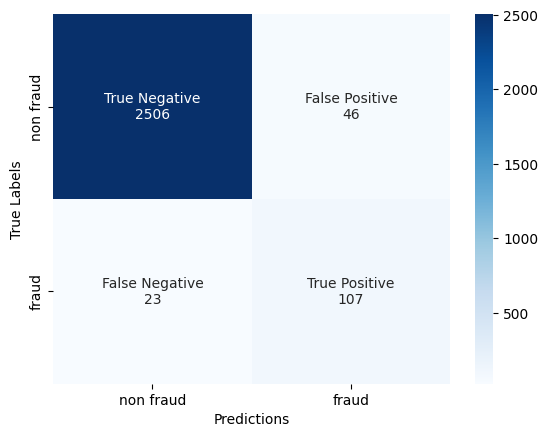

In [19]:
y_pred = final_model.predict([X_test_title,
                X_test_company_profile,
                X_test_description,
                X_test_requirements,
                X_test_benefits,
                X_test_non_text])

final_output = []
for x in y_pred:
    if x<=0.5:
        final_output.append([0])
    else:
        final_output.append([1])
get_confusion_matrix(y_test, final_output, "")    

In [20]:
metrics = {
    'Recall': [metrics.recall_score(y_test,final_output)],
    'Precision': [metrics.precision_score(y_test,final_output)],
    'F1-Score': [metrics.f1_score(y_test,final_output)],
    'Accuracy': [metrics.accuracy_score(y_test,final_output)],
    'ROC AUC': [metrics.roc_auc_score(y_test,final_output)],
}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Recall,Precision,F1-Score,Accuracy,ROC AUC
0,0.823077,0.699346,0.756184,0.974273,0.902526
